Import the libraries needed to run the tool.

Data analysis is performed using [NumPy](https://numpy.org/) and [Pandas](https://pandas.pydata.org/)

Visualization is provided by [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/)

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

Automatically reload the externally defined Python functions created to assist in data analysis

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

Display plots automatically inline

In [4]:
%matplotlib inline

Set the notebook to output plots for high DPI displays, such as 4K monitors or a retina display on Apple hardware

In [5]:
%config InlineBackend.figure_format = 'retina'

Import functions to asssist in data analysis

In [6]:
import charts

Read in a data set that has been run through the [growthcleanr](https://github.com/carriedaymont/growthcleanr) algorithm. Details of the algorithm can be found in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271)

Data is expected to be in a CSV file with the following structure:

| Column | Description |
|--------|-------------|
| id | A unique identifier for an observation |
| subjid | An identifier for the individual from which the observation was obtained |
| sex | A numeric value of 0 (male) or 1 (female). Note that this differs from the CDC Growth Chart Data Tables. |
| agedays | Number representing the age of the patient in days when the observation was obtained |
| param | The type of observation along with units. Expected values are *HEIGHTCM* and *WEIGHTKG* |
| measurement | A decimal number that represents the observation value. |
| clean_value | The categorization of the observation by growthcleanr. |

This information will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [7]:
cleaned_obs = pd.read_csv("clean.csv")

Perform some transformations on the DataFrame. This will create an `age` column, which is a decimal column that represents the patient's age in years at the time of the observation. It changes the `clean_value` column into a [pandas categorical type](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). It also create an `include` column which contains a boolean value indicating whether growthcleanr states to include (true) or exclude (false) the observation. 

In [8]:
obs = charts.setup_individual_obs_df(cleaned_obs)

Load in the [CDC Growth Chart Percentile Data Files](https://www.cdc.gov/growthcharts/percentile_data_files.htm). Functions coerce some values into numeric types. It also add an `age` column which is a decimal value representing age in years. Finally, `Sex` is transformed so that the values align with the values used in growthcleanr, 0 (male) or 1 (female). 

In [9]:
bmi_percentiles = pd.read_csv("bmiagerev.csv")
bmi_percentiles = charts.setup_percentiles(bmi_percentiles)
wt_percentiles = pd.read_csv("wtage.csv")
wt_percentiles = charts.setup_percentiles(wt_percentiles)
ht_percentiles = pd.read_csv("statage.csv")
ht_percentiles = charts.setup_percentiles(ht_percentiles)

This function will create a DataFrame where a height observation and weight observation for the same `subjid` on the same `agedays` are combined into a single row. Several new columns are added to the resulting DataFrame:

| Column | Description |
|--------|-------------|
| weight | The `measurement` value for observations that had the `param` of *WEIGHTKG* |
| height | The `measurement` value for observations that had the `param` of *HEIGHTCM* |
| bmi | The BMI calculated from `weight` and `height` |
| weight_cat | The value previously stored in `clean_value` for the weight observation |
| include_weight | The value previously stored in `include` for the weight observation |
| height_cat | The value previously stored in `clean_value` for the height observation |
| include_height | The value previously stored in `include` for the height observation |
| include_both | Logical AND of `include_weight` and `logical_height` |

In [10]:
merged_df = charts.setup_merged_df(cleaned_obs)

This interactive tool can be used to explore patients. It allows users to find the top or bottom 10 observation based on a set of selected filters.

In [12]:
age_options = [('Any', None)]
for i in range(2, 20):
  age_options.append((str(i), i))

exclusion_options = [('Any', None)]
for c in cleaned_obs.clean_cat.unique():
  exclusion_options.append((c, c))

interact(charts.top_ten, merged_df=fixed(merged_df), field=["height", "weight", "bmi"], 
            age=age_options, 
            sex=[('Any', None), ('Female', 1), ('Male', 0)], 
            exclusion=exclusion_options, order=['largest', 'smallest'])

interactive(children=(Dropdown(description='field', options=('height', 'weight', 'bmi'), value='height'), Drop…

<function charts.top_ten(merged_df, field, age=None, sex=None, exclusion=None, order='largest')>

In [13]:
interactive(charts.overlap_view, obs_df=fixed(obs), 
            subjid=widgets.BoundedIntText(value=47085108,
                                          min=0,
                                          max=100000000,
                                          description='Subject ID:',
                                          disabled=False), 
            param=['HEIGHTCM', 'WEIGHTKG'], 
            include_carry_forward=[True, False], 
            include_percentiles=[True, False],
            wt_df=fixed(wt_percentiles), ht_df=fixed(ht_percentiles))

interactive(children=(BoundedIntText(value=47085108, description='Subject ID:', max=100000000), Dropdown(descr…

Obtain a series that contains the unique set of `subjid`s

In [14]:
uniq_ids = cleaned_obs['subjid'].unique()

Randonly select 16 individuals

In [15]:
sample = np.random.choice(uniq_ids, size=16)

In [16]:
sample

array([47040263, 47062641, 47107251, 46827200, 46789733, 46977302,
       46821797, 46820490, 47070919, 46728134, 47074117, 47103933,
       47117716, 46949846, 46951818, 47066413])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

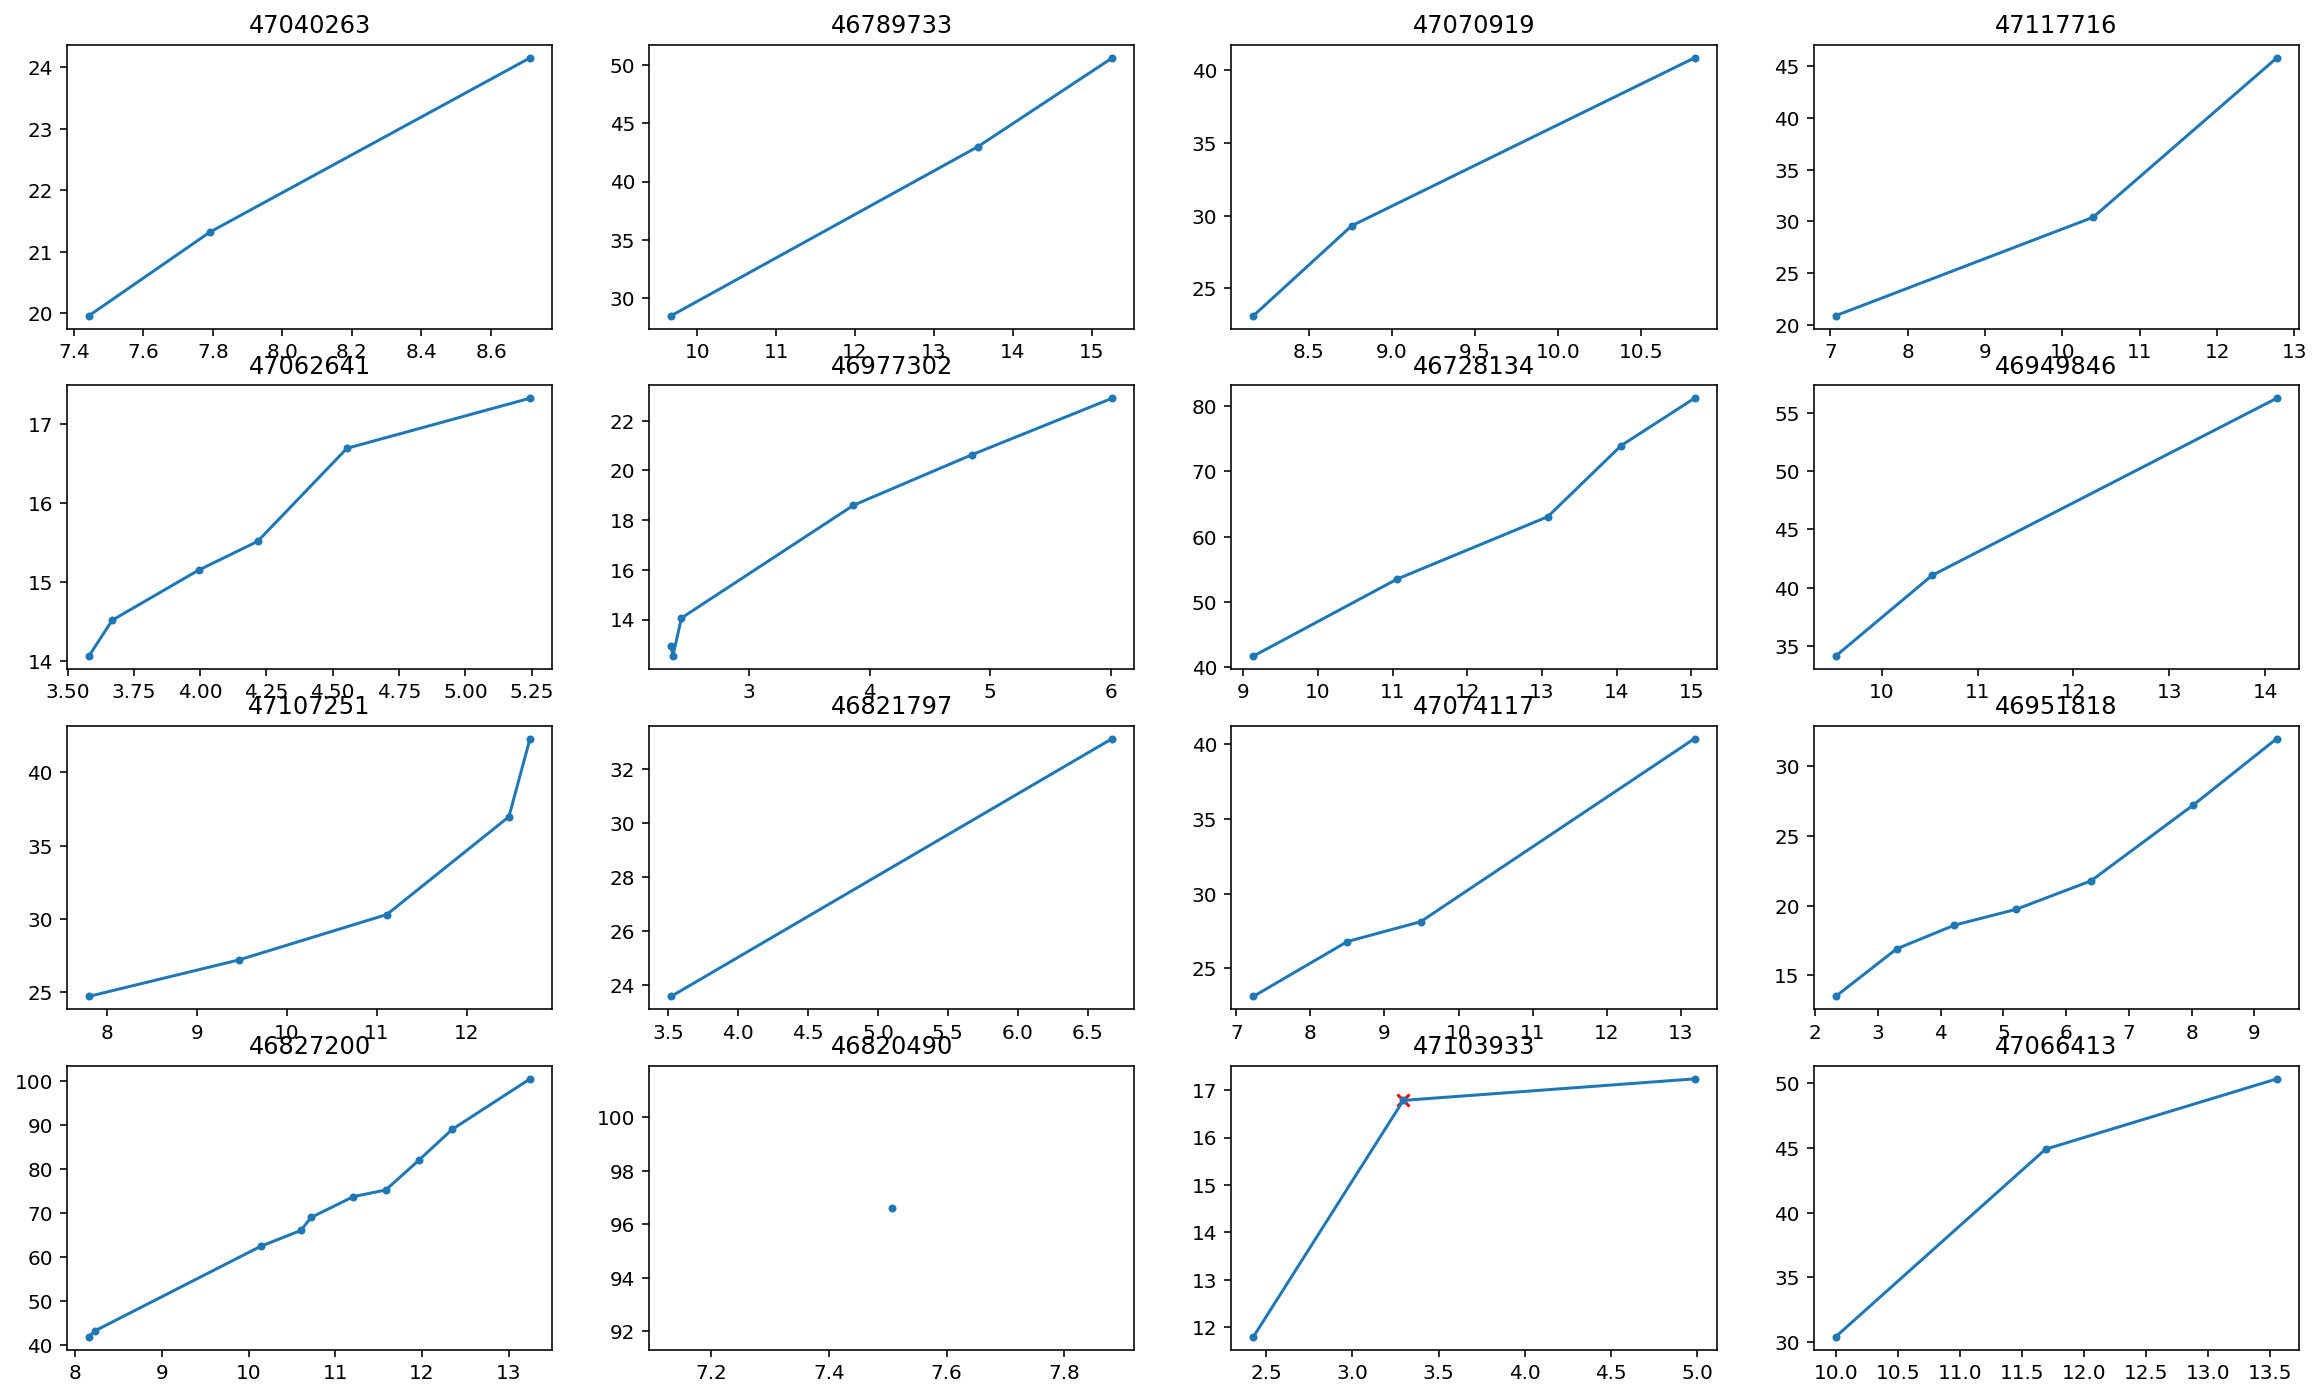

In [17]:
charts.four_by_four_view(cleaned_obs, sample, 'WEIGHTKG')

Display a chart showing BMI for an individual over time. Black bands representing the 5th and 95th BMI percentile for age and sex are shown with the individual's BMI shown in blue.

In [18]:
interact(charts.bmi_with_percentiles, merged_df = fixed(merged_df), 
                                      bmi_percentiles = fixed(bmi_percentiles),
                                      subjid = widgets.BoundedIntText(value=46717134,
                                                                      min=0,
                                                                      max=100000000,
                                                                      description='Subject ID:',
                                                                      disabled=False
))

interactive(children=(BoundedIntText(value=46717134, description='Subject ID:', max=100000000), Output()), _do…

<function charts.bmi_with_percentiles(merged_df, bmi_percentiles, subjid)>

In [19]:
min_toggle = widgets.ToggleButton(value=True, description='Minimum BMI')
mean_toggle = widgets.ToggleButton(value=True, description='Mean BMI')
max_toggle = widgets.ToggleButton(value=True, description='Maximum BMI')
std_toggle = widgets.ToggleButton(value=True, description='BMI Standard Deviation')
med_toggle = widgets.ToggleButton(value=True, description='Median BMI')
count_toggle = widgets.ToggleButton(value=True, description='Count')
diff_toggle = widgets.ToggleButton(value=True, description='Mean BMI Difference')
age_range = widgets.IntRangeSlider(value=[2, 20], min=2, max=20, step=1, description='Age:', continuous_update=False,
                                   orientation='horizontal', readout=True, readout_format='d')
hbox = widgets.HBox([min_toggle, mean_toggle, max_toggle, std_toggle, med_toggle, count_toggle, diff_toggle])
ui = widgets.VBox([age_range, hbox])
out = widgets.Output()
widgets.interactive_output(charts.bmi_stats, {'merged_df': fixed(merged_df), 'include_min': min_toggle, 
         'include_mean': mean_toggle, 'include_max': max_toggle, 'include_std': std_toggle, 
         'include_median': med_toggle, 'include_mean_diff': diff_toggle, 'include_count': count_toggle,
         'out': fixed(out), 'age_range': age_range})
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<pandas.io.formats.style.Styler at 0x1…